# Feature Engineering

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("datasets/eda.csv")

In [3]:
df.dtypes

transaction_date      object
merchant_id            int64
Total_Transaction      int64
Total_Paid           float64
dtype: object

In [4]:
df.transaction_date = pd.to_datetime(df.transaction_date)

In [5]:
df.dtypes

transaction_date     datetime64[ns]
merchant_id                   int64
Total_Transaction             int64
Total_Paid                  float64
dtype: object

In [6]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766


In [7]:
df_535 = df[df["merchant_id"] == 535][["transaction_date", "Total_Transaction"]]

In [8]:
from darts import TimeSeries

series = TimeSeries.from_dataframe(df_535, time_col="transaction_date", value_cols="Total_Transaction")

**Get Seasonal Periods:**

In [9]:
from _utils.ts._dart._dart_utils import Smoother

In [10]:
smooth = Smoother(series, percentage=pd.Timestamp("2020-10-01"))

In [11]:
season_periods = smooth.get_season_period(season_range=366)

2023-05-01 19:25:38,048 - _utils.logging_utils - DEBUG - get_season_period is executing...
2023-05-01 19:25:38,247 - _utils.logging_utils - INFO - Expected Seasonality Periods: 
[7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175, 182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266, 273, 280, 287, 294, 301, 308, 315, 322, 329, 336]


## Adding Statistical Models

In [48]:
from _utils.ts._dart._statistics_utils import ThetaDart, ExponentialSmoothingDart
import warnings

warnings.filterwarnings("ignore")

**Best Theta Model:** <br>
{'theta': 0.28282828282828376, <br>
 'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>, <br>
 'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>, <br>
 'model_mode': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, <br>
 'seasonality_period': 252} <br>
**Best TES Model:** <br>
{'period': 133, <br>
 'smoothing_level': 0.08923501021635089, <br>
 'smoothing_trend': 0.1549716356739671, <br>
 'smoothing_seasonal': 0.2779642424586245, <br>
 'method': 'SLSQP'} <br>

In [13]:
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

theta_params = {
    'theta': 0.28282828282828376,
    'trend_mode': TrendMode.EXPONENTIAL,
    'season_mode': SeasonalityMode.ADDITIVE,
    'model_mode': ModelMode.MULTIPLICATIVE,
    'seasonality_period': 252
}

tes_params = {
    'seasonal_periods': 133,
    'smoothing_level': 0.08923501021635089,
    'smoothing_trend': 0.1549716356739671,
    'smoothing_seasonal': 0.2779642424586245,
    'method': 'SLSQP'
}

In [14]:
length = len(series)

### Theta

In [29]:
from darts.models.forecasting.theta import FourTheta
import numpy as np

thetas = np.zeros(length)
for i in range(length):
    try:
        model = FourTheta(**theta_params)
        model.fit(series[:i])
        thetas[i] = model.predict(1).pd_series()
    except:
        try:
            model = FourTheta(seasonality_period=None)
            model.fit(series[:i])
            thetas[i] = model.predict(1).pd_series()
        except:
            thetas[i] = np.NaN

ValueError: Train series only contains 0 elements but FourTheta(theta=0.28282828282828376, seasonality_period=252, season_mode=SeasonalityMode.ADDITIVE, model_mode=ModelMode.MULTIPLICATIVE, trend_mode=TrendMode.EXPONENTIAL) model requires at least 504 entries
ValueError: Train series only contains 0 elements but FourTheta() model requires at least 3 entries
ValueError: Train series only contains 1 elements but FourTheta(theta=0.28282828282828376, seasonality_period=252, season_mode=SeasonalityMode.ADDITIVE, model_mode=ModelMode.MULTIPLICATIVE, trend_mode=TrendMode.EXPONENTIAL) model requires at least 504 entries
ValueError: Train series only contains 1 elements but FourTheta() model requires at least 3 entries
ValueError: Train series only contains 2 elements but FourTheta(theta=0.28282828282828376, seasonality_period=252, season_mode=SeasonalityMode.ADDITIVE, model_mode=ModelMode.MULTIPLICATIVE, trend_mode=TrendMode.EXPONENTIAL) model requires at least 504 entries
ValueError: Train se

In [31]:
df_535["thetas"] = thetas

In [33]:
df_535.head()

,transaction_date,Total_Transaction,thetas
0,2018-01-01,349,NaN
6,2018-01-02,729,NaN
12,2018-01-03,657,NaN
18,2018-01-04,706,732.333331
25,2018-01-05,648,735.124998


#### Build / Test Model

In [7]:
from _utils.ml._sklearn_models import *
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

In [8]:
def get_score(df, target="Total_Transaction", plot=0):
    temp_df = df.copy()
    temp_df.dropna(inplace=True)
    
    train, test = \
        temp_df[temp_df["transaction_date"] < "2020-10-01"], temp_df[temp_df["transaction_date"] >= "2020-10-01"]
    train.drop("transaction_date", axis=1, inplace=True)
    test.drop("transaction_date", axis=1, inplace=True)
    
    X_train, y_train = train.drop(target, axis=1), train[target]
    X_test, y_test = test.drop(target, axis=1), test[target]
    
    model = LinearRegressionSklearn(X_train, y_train)
    model.init_model()
    
    predictions = model.model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    smape = mean_absolute_percentage_error(y_test, predictions)
    
    if plot:
        graph = pd.DataFrame()
        graph["validation"] = y_test
        graph["predictions"] = predictions
        print(graph)
        graph.plot(figsize=(15, 10))
        plt.title(f"SMAPE: {smape: .3f} - MAE: {mae: .3f}")
        plt.show()
    
    return model.model, {"MAE": mae, "SMAPE": smape}

In [82]:
m, s = get_score(df_535.drop("tes", axis=1))

In [83]:
s

{'MAE': 103.86973739197072, 'SMAPE': 0.06346309681560684}

### TES

In [34]:
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing as TES

In [35]:
tes = np.zeros(length)
for i in range(length):
    try:
        model = TES(**tes_params)
        model.fit(series[:i])
        tes[i] = model.predict(1).pd_series()
    except Exception as e:
        try:
            model = TES()
            model.fit(series[:i])
            tes[i] = model.predict(1).pd_series()
        except:
            tes[i] = np.NaN

ValueError: Train series only contains 0 elements but ExponentialSmoothing(seasonal_periods=133, smoothing_level=0.08923501021635089, smoothing_trend=0.1549716356739671, smoothing_seasonal=0.2779642424586245, method=SLSQP) model requires at least 266 entries
ValueError: Train series only contains 0 elements but ExponentialSmoothing() model requires at least 3 entries
ValueError: Train series only contains 1 elements but ExponentialSmoothing(seasonal_periods=133, smoothing_level=0.08923501021635089, smoothing_trend=0.1549716356739671, smoothing_seasonal=0.2779642424586245, method=SLSQP) model requires at least 266 entries
ValueError: Train series only contains 1 elements but ExponentialSmoothing() model requires at least 3 entries
ValueError: Train series only contains 2 elements but ExponentialSmoothing(seasonal_periods=133, smoothing_level=0.08923501021635089, smoothing_trend=0.1549716356739671, smoothing_seasonal=0.2779642424586245, method=SLSQP) model requires at least 266 entries
V

In [45]:
df_535["tes"] = tes

In [48]:
df_535.head()

,transaction_date,Total_Transaction,thetas,tes
0,2018-01-01,349,NaN,NaN
6,2018-01-02,729,NaN,NaN
12,2018-01-03,657,NaN,NaN
18,2018-01-04,706,732.333331,NaN
25,2018-01-05,648,735.124998,NaN


#### Test Model

In [84]:
m, s = get_score(df_535)

In [85]:
s

{'MAE': 99.16565744346401, 'SMAPE': 0.06144149520637561}

### Prophet

In [60]:
from darts.models.forecasting.prophet_model import Prophet

In [61]:
seasonality = dict({
            'name': "custom_period",  # (name of the seasonality component),
            'seasonal_periods': 252,  # (nr of steps composing a season),
            'fourier_order': 1  # (number of Fourier components to use),
            })

In [62]:
prophs = np.zeros(length)
for i in range(length):
    try:
        model = Prophet(add_seasonalities=seasonality)
        model.fit(series[:i])
        prophs[i] = model.predict(1).pd_series()
    except Exception as e:
        try:
            model = Prophet()
            model.fit(series[:i])
            prophs[i] = model.predict(1).pd_series()
        except:
            prophs[i] = np.NaN

ValueError: Train series only contains 0 elements but Prophet(add_seasonalities={'name': 'custom_period', 'seasonal_periods': 252, 'fourier_order': 1}) model requires at least 3 entries
ValueError: Train series only contains 0 elements but Prophet() model requires at least 3 entries
ValueError: Train series only contains 1 elements but Prophet(add_seasonalities={'name': 'custom_period', 'seasonal_periods': 252, 'fourier_order': 1}) model requires at least 3 entries
ValueError: Train series only contains 1 elements but Prophet() model requires at least 3 entries
ValueError: Train series only contains 2 elements but Prophet(add_seasonalities={'name': 'custom_period', 'seasonal_periods': 252, 'fourier_order': 1}) model requires at least 3 entries
ValueError: Train series only contains 2 elements but Prophet() model requires at least 3 entries
20:01:10 - cmdstanpy - INFO - Chain [1] start processing
20:01:10 - cmdstanpy - INFO - Chain [1] done processing
20:01:10 - cmdstanpy - INFO - Chain

In [86]:
df_535["prophet"] = prophs

In [87]:
df_535.head()

,transaction_date,Total_Transaction,thetas,tes,prophet
0,2018-01-01,349,NaN,NaN,NaN
6,2018-01-02,729,NaN,NaN,NaN
12,2018-01-03,657,NaN,NaN,NaN
18,2018-01-04,706,732.333331,NaN,885.328451
25,2018-01-05,648,735.124998,NaN,858.676969


#### Test Model

In [88]:
m, s = get_score(df_535)

In [89]:
s

{'MAE': 98.12314484264797, 'SMAPE': 0.06100033215163471}

### Kalman

In [90]:
from darts.models.forecasting.kalman_forecaster import KalmanForecaster

In [93]:
kalman = np.zeros(length)
for i in range(length):
    try:
        model = KalmanForecaster(dim_x=68)
        model.fit(series[:i])
        kalman[i] = model.predict(1).pd_series()
    except Exception as e:
        try:
            model = KalmanForecaster()
            model.fit(series[:i])
            kalman[i] = model.predict(1).pd_series()
        except:
            kalman[i] = np.NaN

ValueError: Train series only contains 0 elements but KalmanForecaster(dim_x=68) model requires at least 3 entries
ValueError: Train series only contains 0 elements but KalmanForecaster() model requires at least 3 entries
ValueError: Train series only contains 1 elements but KalmanForecaster(dim_x=68) model requires at least 3 entries
ValueError: Train series only contains 1 elements but KalmanForecaster() model requires at least 3 entries
ValueError: Train series only contains 2 elements but KalmanForecaster(dim_x=68) model requires at least 3 entries
ValueError: Train series only contains 2 elements but KalmanForecaster() model requires at least 3 entries


In [95]:
df_535["kalman"] = kalman

#### Test Model

In [97]:
m, s = get_score(df_535)

In [98]:
s

{'MAE': 94.29698012662865, 'SMAPE': 0.05855138707163762}

      validation  predictions
7023        2468  2248.668013
7030        2132  2124.567184
7037        1883  1903.754350
7044        1828  1821.534777
7051        2303  2120.723072
...          ...          ...
7632        1574  1332.330130
7639        1764  1734.304049
7646        1537  1708.807529
7653        1353  1655.193524
7660         838  1512.081290

[92 rows x 2 columns]


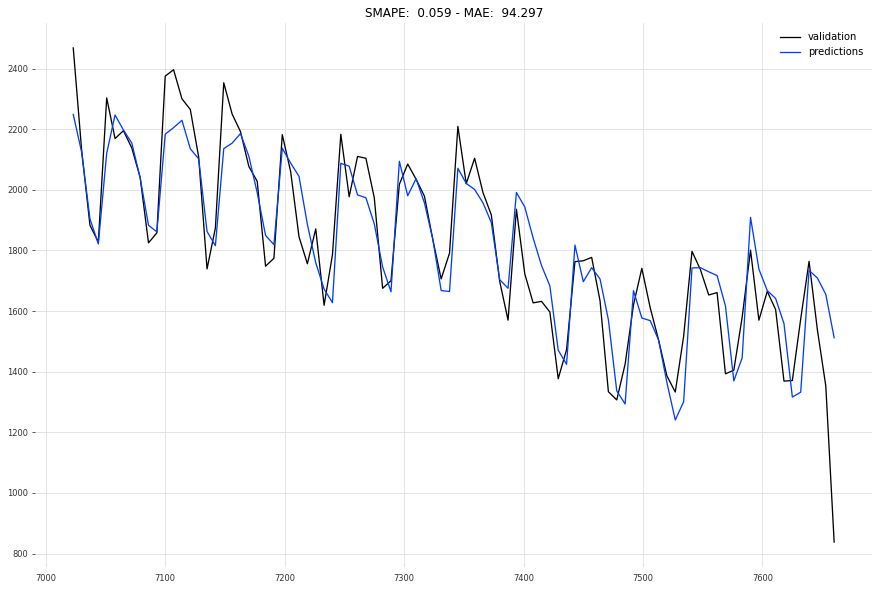

(LinearRegression(), {'MAE': 94.29698012662865, 'SMAPE': 0.05855138707163762})

In [120]:
get_score(df_535, plot=1)

## Date Extraction

In [121]:
def create_date_features(df, date_column):
    features = {'month', 'day_of_month', 'day_of_year', 'day_of_week', 'is_wknd', 
               'is_month_start', 'is_month_end', 'quarter', 'is_quarter_start', 'is_quarter_end',
               'is_year_start', 'is_year_end', 'week_of_year'}
    
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.weekofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] = df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    
    return df, features

In [137]:
temp_df = df_535.copy()
temp_df, features = create_date_features(temp_df, "transaction_date")

In [138]:
temp_df.head()

,transaction_date,Total_Transaction,thetas,tes,prophet,kalman,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01,349,NaN,NaN,NaN,NaN,1,1,1,1,0,0,1,0,1,1,0,1,0
6,2018-01-02,729,NaN,NaN,NaN,NaN,1,2,2,1,1,0,0,0,1,0,0,0,0
12,2018-01-03,657,NaN,NaN,NaN,NaN,1,3,3,1,2,0,0,0,1,0,0,0,0
18,2018-01-04,706,732.333331,NaN,885.328451,NaN,1,4,4,1,3,0,0,0,1,0,0,0,0
25,2018-01-05,648,735.124998,NaN,858.676969,NaN,1,5,5,1,4,1,0,0,1,0,0,0,0


In [125]:
ohe_cols = {'month', 'day_of_month', 'day_of_year', 'week_of_year', 'day_of_week'}

In [147]:
best_mae = 94.29698012662865

In [129]:
df_535.columns

Index(['transaction_date', 'Total_Transaction', 'thetas', 'tes', 'prophet',
       'kalman'],
      dtype='object')

In [136]:
temp_df.columns

Index(['is_quarter_end', 'Total_Transaction', 'thetas', 'tes', 'prophet',
       'kalman'],
      dtype='object')

In [148]:
for col in features:
    temp_df2 = temp_df.copy()
    temp_df2 = temp_df2[['transaction_date', 'Total_Transaction', 
                       'thetas', 'tes', 'prophet', 'kalman', col]]

    if col in ohe_cols:
        temp_df2 = pd.get_dummies(temp_df2, columns=[col])
        
    m, s = get_score(temp_df2)
    
    if s["MAE"] < best_mae:
        print("First Score: ", best_mae, "Last Score: ", s)
        print(f"{col} is successed.")
        best_mae = s["MAE"]
    else:
        temp_df.drop(col, axis=1, inplace=True)

First Score:  94.29698012662865 Last Score:  {'MAE': 93.52965120385922, 'SMAPE': 0.05796927784432168}
is_month_end is successed.
First Score:  93.52965120385922 Last Score:  {'MAE': 88.99838171768563, 'SMAPE': 0.05237915498776771}
is_year_end is successed.


In [150]:
df_535 = temp_df

In [152]:
best_mae = 88.99838171768563

      validation  predictions
7023        2468  2249.423109
7030        2132  2125.462018
7037        1883  1904.997675
7044        1828  1823.467375
7051        2303  2123.195485
...          ...          ...
7632        1574  1334.207664
7639        1764  1735.813759
7646        1537  1709.673010
7653        1353  1656.374017
7660         838  1040.080202

[92 rows x 2 columns]


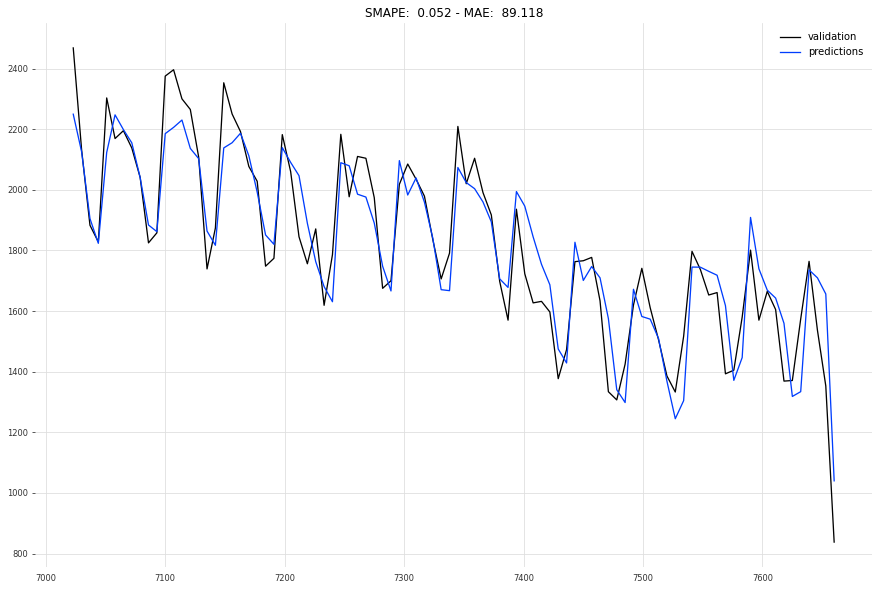

(LinearRegression(), {'MAE': 89.11757998882109, 'SMAPE': 0.05244575392405244})

In [153]:
get_score(df_535, plot=1)

### Black Friday

In [154]:
temp_df = df_535.copy()

In [155]:
temp_df["is_black_friday"] = temp_df["transaction_date"].dt.month.apply(lambda x: 1 if x == 11 else 0)

In [156]:
m, s = get_score(temp_df)
    
if s["MAE"] < best_mae:
    print("First Score: ", best_mae, "Last Score: ", s)
    print("Feature Extraction is successed.")
    best_mae = s["MAE"]
else:
    print("Feature Extraction is failed.")
    temp_df.drop("is_black_friday", axis=1, inplace=True)

Feature Extraction is failed.


In [157]:
s["MAE"]

89.1398058483793

### Qurban Festival

In [158]:
temp_df = df_535.copy()

In [159]:
temp_df.dropna()["transaction_date"].min(), temp_df.dropna()["transaction_date"].max()

(Timestamp('2018-01-15 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [160]:
temp_df["is_qurban"] = 0

In [161]:
qurban = ["2019-08-05", "2019-08-06", "2019-08-07", "2019-08-08", "2019-08-09", "2019-08-10",
         "2020-07-25", "2020-07-26", "2020-07-27", "2020-08-28", "2020-08-29", "2020-08-30"]

In [162]:
temp_df.loc[temp_df['transaction_date'].isin(qurban), "is_qurban"] = 1

In [164]:
m, s = get_score(temp_df)
    
if s["MAE"] < best_mae:
    print("First Score: ", best_mae, "Last Score: ", s)
    print("Feature Extraction is successed.")
    best_mae = s["MAE"]
else:
    print("Feature Extraction is failed.")
    temp_df.drop("is_qurban", axis=1, inplace=True)

Feature Extraction is failed.


In [165]:
s["MAE"]

89.29261582289139

### Ramadan Festival

In [166]:
temp_df = df_535.copy()

In [167]:
temp_df["is_ramadan"] = 0

In [168]:
ramadan = ["2019-05-29", "2019-05-30", "2019-05-31", "2019-06-01", "2019-06-02", "2019-06-03",
          "2020-05-18", "2020-05-19", "2020-05-20", "2020-05-23", "2020-05-22", "2020-05-21"]

In [169]:
temp_df.loc[temp_df['transaction_date'].isin(ramadan), "is_ramadan"] = 1

In [170]:
m, s = get_score(temp_df)
    
if s["MAE"] < best_mae:
    print("First Score: ", best_mae, "Last Score: ", s)
    print("Feature Extraction is successed.")
    best_mae = s["MAE"]
else:
    print("Feature Extraction is failed.")
    temp_df.drop("is_ramadan", axis=1, inplace=True)

Feature Extraction is failed.


In [171]:
s["MAE"]

89.89436488619812

## Lag / Shifted Features

In [174]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [172]:
best_mae

88.99838171768563

In [175]:
temp_df = df_535.copy()
for period in season_periods:
    temp_df = lag_features(temp_df, [period])
    
    m, s = get_score(temp_df)
    
    if s["MAE"] < best_mae:
        print("First Score: ", best_mae, "Last Score: ", s)
        best_mae = s["MAE"]
    else:
        temp_df.drop("sales_lag_" + str(period), axis=1, inplace=True)

First Score:  88.99838171768563 Last Score:  {'MAE': 88.22054028631858, 'SMAPE': 0.051848567458049354}
is_wknd is successed.
First Score:  88.22054028631858 Last Score:  {'MAE': 86.42443491266177, 'SMAPE': 0.051060897646972865}
is_wknd is successed.
First Score:  86.42443491266177 Last Score:  {'MAE': 86.28118222805351, 'SMAPE': 0.05093729672266888}
is_wknd is successed.
First Score:  86.28118222805351 Last Score:  {'MAE': 86.20769484068403, 'SMAPE': 0.05084822327084419}
is_wknd is successed.
First Score:  86.20769484068403 Last Score:  {'MAE': 86.0421008171986, 'SMAPE': 0.05072595776434554}
is_wknd is successed.
First Score:  86.0421008171986 Last Score:  {'MAE': 83.8714520383999, 'SMAPE': 0.04922346534971422}
is_wknd is successed.


In [176]:
temp_df.head()

,transaction_date,Total_Transaction,thetas,tes,prophet,kalman,is_month_end,is_year_end,sales_lag_7,sales_lag_14,sales_lag_49,sales_lag_56,sales_lag_63,sales_lag_91
0,2018-01-01,349,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-01-02,729,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
12,2018-01-03,657,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
18,2018-01-04,706,732.333331,NaN,885.328451,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
25,2018-01-05,648,735.124998,NaN,858.676969,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
df_535 = temp_df

## Rolling Mean Features

In [179]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe['Total_Transaction']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [178]:
best_mae

83.8714520383999

In [180]:
temp_df = df_535.copy()
for period in season_periods:
    temp_df = roll_mean_features(temp_df, [period])
    
    m, s = get_score(temp_df)
    
    if s["MAE"] < best_mae:
        print("First Score: ", best_mae, "Last Score: ", s)
        best_mae = s["MAE"]
    else:
        temp_df.drop("sales_roll_mean_" + str(period), axis=1, inplace=True)

First Score:  83.8714520383999 Last Score:  {'MAE': 83.58407424798189, 'SMAPE': 0.049097290477483714}


In [181]:
temp_df.head()

,transaction_date,Total_Transaction,thetas,tes,prophet,kalman,is_month_end,is_year_end,sales_lag_7,sales_lag_14,sales_lag_49,sales_lag_56,sales_lag_63,sales_lag_91,sales_roll_mean_7
0,2018-01-01,349,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-01-02,729,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2018-01-03,657,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2018-01-04,706,732.333331,NaN,885.328451,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,2018-01-05,648,735.124998,NaN,858.676969,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
df_535 = temp_df

## Exponentially Weighted Mean Features

In [183]:
from itertools import product

alphas = np.arange(0.01, 0.99, 0.02)

package = product(alphas, season_periods)

In [184]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [185]:
best_mae

83.58407424798189

In [186]:
temp_df = df_535.copy()
for alpha, period in package:
    temp_df = ewm_features(temp_df, [alpha], [period])
    
    m, s = get_score(temp_df)
    
    if s["MAE"] < best_mae:
        print("First Score: ", best_mae, "Last Score: ", s)
        best_mae = s["MAE"]
    else:
        temp_df.drop('sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(period), 
                     axis=1, inplace=True)

First Score:  83.58407424798189 Last Score:  {'MAE': 82.82646318533243, 'SMAPE': 0.048486860003248006}
First Score:  82.82646318533243 Last Score:  {'MAE': 82.47189971113687, 'SMAPE': 0.04833166314559021}
First Score:  82.47189971113687 Last Score:  {'MAE': 82.36241603528762, 'SMAPE': 0.0482612040393717}
First Score:  82.36241603528762 Last Score:  {'MAE': 82.19389509401691, 'SMAPE': 0.0481587624074896}
First Score:  82.19389509401691 Last Score:  {'MAE': 81.85544949997934, 'SMAPE': 0.04780529766422953}
First Score:  81.85544949997934 Last Score:  {'MAE': 81.43662558613124, 'SMAPE': 0.04737635831615298}
First Score:  81.43662558613124 Last Score:  {'MAE': 81.40387653531506, 'SMAPE': 0.04736419034816076}
First Score:  81.40387653531506 Last Score:  {'MAE': 81.0607941958043, 'SMAPE': 0.04708495689164339}
First Score:  81.0607941958043 Last Score:  {'MAE': 81.0072166129759, 'SMAPE': 0.0470467367185615}
First Score:  81.0072166129759 Last Score:  {'MAE': 80.73493657882314, 'SMAPE': 0.04657

In [187]:
temp_df.head()

,transaction_date,Total_Transaction,thetas,tes,prophet,kalman,is_month_end,is_year_end,sales_lag_7,sales_lag_14,sales_lag_49,sales_lag_56,sales_lag_63,sales_lag_91,sales_roll_mean_7,sales_ewm_alpha_001_lag_182,sales_ewm_alpha_001_lag_189,sales_ewm_alpha_006999999999999999_lag_14,sales_ewm_alpha_006999999999999999_lag_21,sales_ewm_alpha_008999999999999998_lag_7,sales_ewm_alpha_008999999999999998_lag_28,sales_ewm_alpha_008999999999999998_lag_35,sales_ewm_alpha_010999999999999997_lag_7,sales_ewm_alpha_012999999999999998_lag_42,sales_ewm_alpha_016999999999999998_lag_140,sales_ewm_alpha_018999999999999997_lag_105,sales_ewm_alpha_018999999999999997_lag_112,sales_ewm_alpha_018999999999999997_lag_119,sales_ewm_alpha_020999999999999996_lag_63,sales_ewm_alpha_022999999999999998_lag_35,sales_ewm_alpha_022999999999999998_lag_49,sales_ewm_alpha_022999999999999998_lag_84,sales_ewm_alpha_024999999999999997_lag_21,sales_ewm_alpha_024999999999999997_lag_56,sales_ewm_alpha_024999999999999997_lag_63,sales_ewm_alpha_024999999999999997_lag_70,sales_ewm_alpha_024999999999999997_lag_77,sales_ewm_alpha_024999999999999997_lag_91,sales_ewm_alpha_024999999999999997_lag_98,sales_ewm_alpha_026999999999999996_lag_77,sales_ewm_alpha_026999999999999996_lag_91,sales_ewm_alpha_029_lag_77,sales_ewm_alpha_030999999999999994_lag_49,sales_ewm_alpha_036999999999999994_lag_98,sales_ewm_alpha_038999999999999996_lag_91,sales_ewm_alpha_038999999999999996_lag_105,sales_ewm_alpha_044999999999999996_lag_7,sales_ewm_alpha_057_lag_105,sales_ewm_alpha_059_lag_21,sales_ewm_alpha_059_lag_35,sales_ewm_alpha_059_lag_147,sales_ewm_alpha_06099999999999999_lag_49,sales_ewm_alpha_07299999999999999_lag_49,sales_ewm_alpha_07299999999999999_lag_91,sales_ewm_alpha_07499999999999999_lag_91,sales_ewm_alpha_08499999999999999_lag_119,sales_ewm_alpha_08699999999999999_lag_147,sales_ewm_alpha_08899999999999999_lag_14,sales_ewm_alpha_08899999999999999_lag_140,sales_ewm_alpha_09299999999999998_lag_63,sales_ewm_alpha_09699999999999999_lag_35
0,2018-01-01,349,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-01-02,729,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2018-01-03,657,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,2018-01-04,706,732.333331,NaN,885.328451,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,2018-01-05,648,735.124998,NaN,858.676969,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
df_535 = temp_df

**Graph**

      validation  predictions
7023        2468  2423.477459
7030        2132  2245.433275
7037        1883  1898.890582
7044        1828  1822.973529
7051        2303  2103.437605
...          ...          ...
7632        1574  1392.453467
7639        1764  1792.824777
7646        1537  1681.421312
7653        1353  1573.560201
7660         838   931.147041

[92 rows x 2 columns]


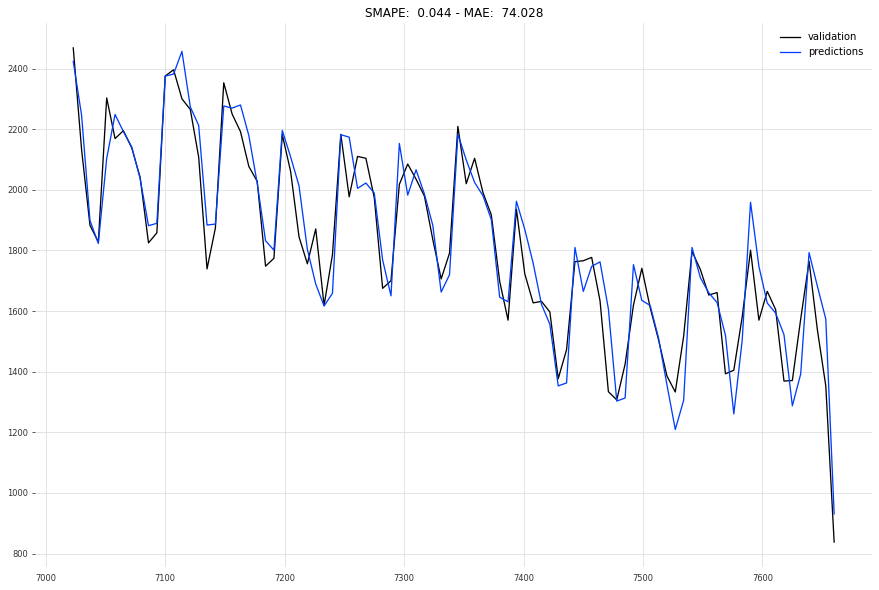

(LinearRegression(), {'MAE': 74.02848106977171, 'SMAPE': 0.04384770582878808})

In [190]:
get_score(df_535, plot=1)

## Dollar / TL

### Iyzico Dataset

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("datasets/processed.csv")

In [4]:
df.dtypes

transaction_date                              object
Total_Transaction                              int64
thetas                                       float64
tes                                          float64
prophet                                      float64
                                              ...   
sales_ewm_alpha_08699999999999999_lag_147    float64
sales_ewm_alpha_08899999999999999_lag_14     float64
sales_ewm_alpha_08899999999999999_lag_140    float64
sales_ewm_alpha_09299999999999998_lag_63     float64
sales_ewm_alpha_09699999999999999_lag_35     float64
Length: 61, dtype: object

In [5]:
df.transaction_date = pd.to_datetime(df.transaction_date)

In [6]:
df.dtypes

transaction_date                             datetime64[ns]
Total_Transaction                                     int64
thetas                                              float64
tes                                                 float64
prophet                                             float64
                                                  ...      
sales_ewm_alpha_08699999999999999_lag_147           float64
sales_ewm_alpha_08899999999999999_lag_14            float64
sales_ewm_alpha_08899999999999999_lag_140           float64
sales_ewm_alpha_09299999999999998_lag_63            float64
sales_ewm_alpha_09699999999999999_lag_35            float64
Length: 61, dtype: object

In [9]:
df.transaction_date.min(), df.transaction_date.max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

### Dollar Dataset

In [10]:
dollar = pd.read_csv("datasets/usd.csv")

In [11]:
dollar.head()

,Tarih,Şimdi,Açılış,Yüksek,Düşük,Hac.,Fark %
0,31.12.2020,"7,4370","7,3835","7,4960","7,3456",NaN,"0,15%"
1,30.12.2020,"7,4257","7,3785","7,4921","7,3429",NaN,"0,59%"
2,30.12.2020,"7,3823","7,3874","7,3980","7,3009",NaN,"-0,02%"
3,29.12.2020,"7,3837","7,3775","7,3941","7,2975",NaN,"-0,04%"
4,29.12.2020,"7,3865","7,4496","7,4798","7,3330",NaN,"0,07%"


In [12]:
dollar.dtypes

Tarih      object
Şimdi      object
Açılış     object
Yüksek     object
Düşük      object
Hac.      float64
Fark %     object
dtype: object

In [13]:
dollar.Tarih = pd.to_datetime(dollar.Tarih)

C:\Users\talha\AppData\Local\Temp\ipykernel_2572\3875689373.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dollar.Tarih = pd.to_datetime(dollar.Tarih)


In [14]:
dollar.dtypes

Tarih     datetime64[ns]
Şimdi             object
Açılış            object
Yüksek            object
Düşük             object
Hac.             float64
Fark %            object
dtype: object

In [18]:
dollar["Şimdi"] = dollar["Şimdi"].apply(lambda x: float(x.replace(",", ".")))

In [19]:
dollar.head()

,Tarih,Şimdi,Açılış,Yüksek,Düşük,Hac.,Fark %
0,2020-12-31,7.4370,"7,3835","7,4960","7,3456",NaN,"0,15%"
1,2020-12-30,7.4257,"7,3785","7,4921","7,3429",NaN,"0,59%"
2,2020-12-30,7.3823,"7,3874","7,3980","7,3009",NaN,"-0,02%"
3,2020-12-29,7.3837,"7,3775","7,3941","7,2975",NaN,"-0,04%"
4,2020-12-29,7.3865,"7,4496","7,4798","7,3330",NaN,"0,07%"


In [20]:
dollar.dtypes

Tarih     datetime64[ns]
Şimdi            float64
Açılış            object
Yüksek            object
Düşük             object
Hac.             float64
Fark %            object
dtype: object

In [22]:
dollar.drop(["Açılış", "Yüksek", "Düşük", "Hac.", "Fark %"], axis=1, inplace=True)

In [26]:
dollar.columns = ["transaction_date", "dollar"]

In [27]:
dollar.head()

,transaction_date,dollar
0,2020-12-31,7.4370
1,2020-12-30,7.4257
2,2020-12-30,7.3823
3,2020-12-29,7.3837
4,2020-12-29,7.3865


In [28]:
dollar.dtypes

transaction_date    datetime64[ns]
dollar                     float64
dtype: object

In [29]:
temp_df = df.copy()

In [44]:
temp_df = pd.merge(temp_df, dollar, on="transaction_date")

### Test

In [45]:
get_score(temp_df)

C:\Users\talha\AppData\Local\Temp\ipykernel_2572\2288487489.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop("transaction_date", axis=1, inplace=True)
C:\Users\talha\AppData\Local\Temp\ipykernel_2572\2288487489.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop("transaction_date", axis=1, inplace=True)


(LinearRegression(), {'MAE': 78.11015463150801, 'SMAPE': 0.044134779627624285})

It failed. MAE increased 74 to 78.

## Corona

In [47]:
temp_df = df.copy()

In [49]:
temp_df["is_corona"] = 0

In [50]:
temp_df["is_corona"] = temp_df["transaction_date"].dt.year.apply(lambda x: 1 if x == 2020 else 0)

In [51]:
temp_df

,transaction_date,Total_Transaction,thetas,tes,prophet,kalman,is_month_end,is_year_end,sales_lag_7,sales_lag_14,sales_lag_49,sales_lag_56,sales_lag_63,sales_lag_91,sales_roll_mean_7,sales_ewm_alpha_001_lag_182,sales_ewm_alpha_001_lag_189,sales_ewm_alpha_006999999999999999_lag_14,sales_ewm_alpha_006999999999999999_lag_21,sales_ewm_alpha_008999999999999998_lag_7,sales_ewm_alpha_008999999999999998_lag_28,sales_ewm_alpha_008999999999999998_lag_35,sales_ewm_alpha_010999999999999997_lag_7,sales_ewm_alpha_012999999999999998_lag_42,sales_ewm_alpha_016999999999999998_lag_140,sales_ewm_alpha_018999999999999997_lag_105,sales_ewm_alpha_018999999999999997_lag_112,sales_ewm_alpha_018999999999999997_lag_119,sales_ewm_alpha_020999999999999996_lag_63,sales_ewm_alpha_022999999999999998_lag_35,sales_ewm_alpha_022999999999999998_lag_49,sales_ewm_alpha_022999999999999998_lag_84,sales_ewm_alpha_024999999999999997_lag_21,sales_ewm_alpha_024999999999999997_lag_56,sales_ewm_alpha_024999999999999997_lag_63,sales_ewm_alpha_024999999999999997_lag_70,sales_ewm_alpha_024999999999999997_lag_77,sales_ewm_alpha_024999999999999997_lag_91,sales_ewm_alpha_024999999999999997_lag_98,sales_ewm_alpha_026999999999999996_lag_77,sales_ewm_alpha_026999999999999996_lag_91,sales_ewm_alpha_029_lag_77,sales_ewm_alpha_030999999999999994_lag_49,sales_ewm_alpha_036999999999999994_lag_98,sales_ewm_alpha_038999999999999996_lag_91,sales_ewm_alpha_038999999999999996_lag_105,sales_ewm_alpha_044999999999999996_lag_7,sales_ewm_alpha_057_lag_105,sales_ewm_alpha_059_lag_21,sales_ewm_alpha_059_lag_35,sales_ewm_alpha_059_lag_147,sales_ewm_alpha_06099999999999999_lag_49,sales_ewm_alpha_07299999999999999_lag_49,sales_ewm_alpha_07299999999999999_lag_91,sales_ewm_alpha_07499999999999999_lag_91,sales_ewm_alpha_08499999999999999_lag_119,sales_ewm_alpha_08699999999999999_lag_147,sales_ewm_alpha_08899999999999999_lag_14,sales_ewm_alpha_08899999999999999_lag_140,sales_ewm_alpha_09299999999999998_lag_63,sales_ewm_alpha_09699999999999999_lag_35,is_corona
0,2018-01-01,349,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2018-01-02,729,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2018-01-03,657,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2018-01-04,706,732.333331,NaN,885.328451,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2018-01-05,648,735.124998,NaN,858.676969,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,1574,1273.166023,1322.881769,1378.954113,1432.604578,0,0,1581.967880,1515.672963,1700.349764,1783.603327,1777.332425,1802.229153,1591.718435,1404.792648,1382.439132,1625.472425,1697.425604,1584.231806,1757.108238,1907.895644,1569.298653,1898.221889,1587.833538,2043.756060,1969.223044,1923.712663,1980.898127,1833.119941,1870.580560,2082.272789,1496.396450,1824.924838,1957.601533,2026.724512,2000.870330,1989.152029,2007.534452,19

In [53]:
m, s = get_score(df)

In [55]:
best_mae = s["MAE"]
best_mae

74.02848106979707

In [52]:
get_score(temp_df)

(LinearRegression(), {'MAE': 74.63865083850105, 'SMAPE': 0.04423603424153774})

It failed again. Let's general look for corona period.

In [59]:
time = temp_df[temp_df["is_corona"] == 1]["transaction_date"]
transaction = temp_df[temp_df["is_corona"] == 1]["Total_Transaction"]

In [60]:
import matplotlib.pyplot as plt

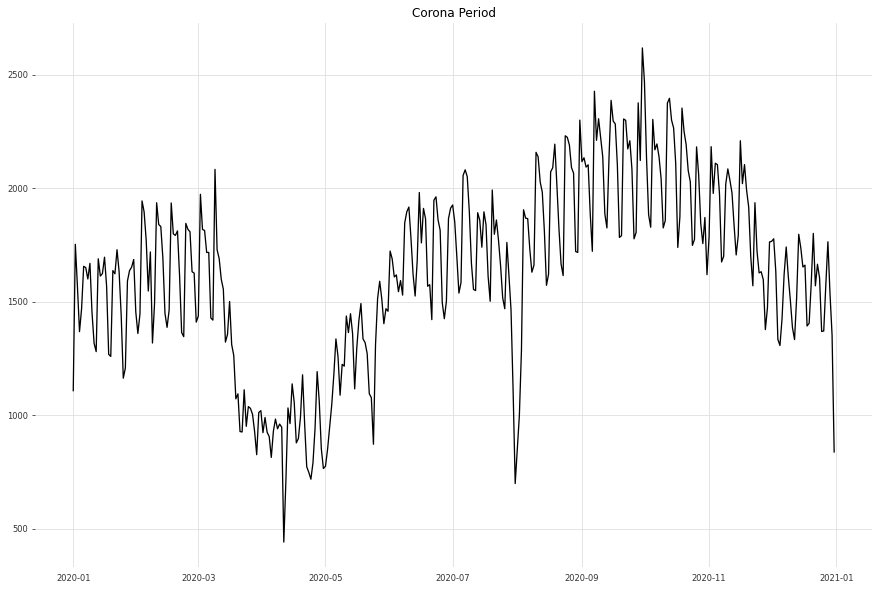

In [63]:
plt.figure(figsize=(15, 10))

plt.title("Corona Period")
plt.plot(time, transaction)

plt.show()

## Segmentation

In [97]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import numpy as np

In [117]:
best_mae

74.02848106979707

In [135]:
K = [k for k in range(2, 50)]
distortions = []
for k in range(2, 50):
    temp_df = df.copy()
    temp_df.dropna(inplace=True)
    
    model = KMeans(n_clusters=k, random_state=7).fit(temp_df.drop(["transaction_date", "Total_Transaction"], 
                                                                  axis=1))
    
    distortions.append(np.sum(np.min(
        cdist(temp_df.drop(["transaction_date", "Total_Transaction"], axis=1), 
              model.cluster_centers_, "euclidean"), axis=1)) / temp_df.shape[0])
    
    temp_df["segment"] = model.fit_predict(temp_df.drop(["transaction_date", "Total_Transaction"], axis=1))
    
    m, s = get_score(temp_df)
    
    if s["MAE"] < best_mae:
        print("Label Encoding")
        print(f"{k} K - Score: {s}")
        
    m, s = get_score(pd.get_dummies(temp_df, columns=["segment"]))
    
    if s["MAE"] < best_mae:
        print("One Hot Encoding")
        print(f"{k} K - Score: {s}")

Label Encoding
13 K - Score: {'MAE': 74.0106582692854, 'SMAPE': 0.04389553783108443}
Label Encoding
20 K - Score: {'MAE': 74.02683898259656, 'SMAPE': 0.043845546694520725}
Label Encoding
25 K - Score: {'MAE': 74.0119643910227, 'SMAPE': 0.0437419249201974}
Label Encoding
27 K - Score: {'MAE': 73.99225697673508, 'SMAPE': 0.043799141145986445}
Label Encoding
28 K - Score: {'MAE': 73.9670737908142, 'SMAPE': 0.04381973709200163}
Label Encoding
29 K - Score: {'MAE': 73.98374351694021, 'SMAPE': 0.04376191206753294}
Label Encoding
30 K - Score: {'MAE': 73.18266577530099, 'SMAPE': 0.043160854862461566}
Label Encoding
31 K - Score: {'MAE': 74.01424790924237, 'SMAPE': 0.04381953107900747}
Label Encoding
32 K - Score: {'MAE': 74.02161071669217, 'SMAPE': 0.04380430241186578}
Label Encoding
35 K - Score: {'MAE': 73.5818758539821, 'SMAPE': 0.04354485310234015}
Label Encoding
36 K - Score: {'MAE': 74.00169249733867, 'SMAPE': 0.04376662219624445}
Label Encoding
38 K - Score: {'MAE': 73.36335014489096, 

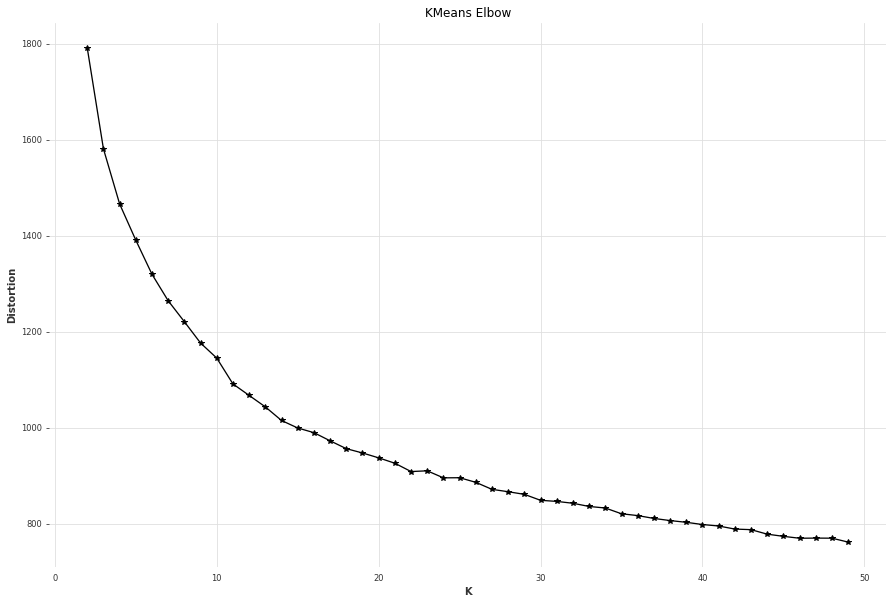

In [136]:
#%matplotlib qt
%matplotlib inline
plt.figure(figsize=(15, 10))

plt.title("KMeans Elbow")
plt.xlabel("K")
plt.ylabel("Distortion")
plt.plot(K, distortions, "*-")

plt.show()

In [137]:
temp_df = df.copy()

In [138]:
temp_df.dropna(inplace=True)

In [139]:
model = KMeans(n_clusters=30, random_state=7)

In [140]:
temp_df["segment"] = model.fit_predict(temp_df.drop(["transaction_date", "Total_Transaction"], axis=1))

In [141]:
temp_df.segment.value_counts()

26    82
18    82
9     59
29    56
2     53
8     53
0     51
16    34
21    31
1     30
19    27
24    27
11    25
7     23
13    22
12    21
27    20
5     19
6     19
23    18
15    18
28    18
25    17
3     16
22    16
4     16
17    15
10    14
20    13
14    12
Name: segment, dtype: int64

In [142]:
get_score(temp_df)

(LinearRegression(), {'MAE': 73.18266577530099, 'SMAPE': 0.043160854862461566})

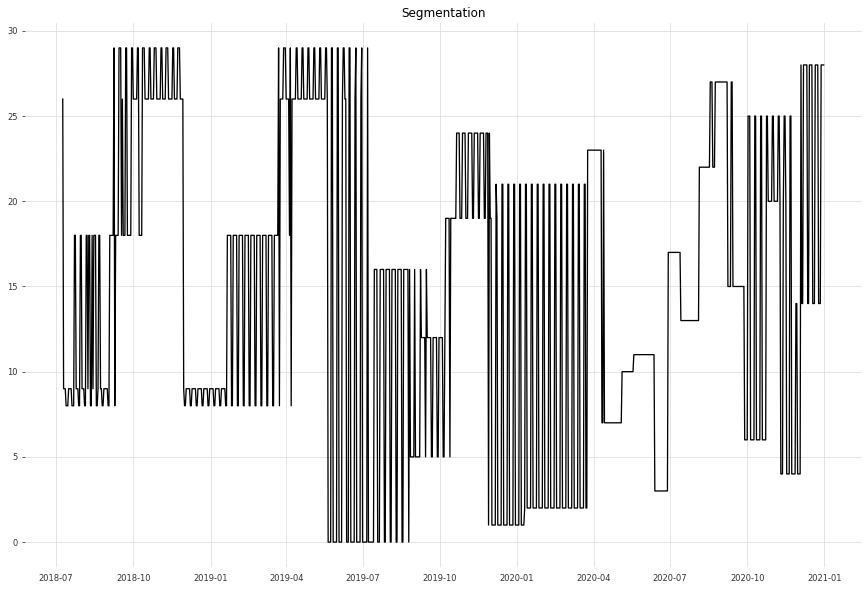

In [144]:
plt.figure(figsize=(15, 10))

plt.title("Segmentation")
plt.plot(temp_df["transaction_date"], temp_df["segment"])

plt.show()

In [154]:
df = temp_df[["transaction_date", "segment"]].merge(df)

     validation  predictions
815        2468  2427.961184
816        2132  2239.442505
817        1883  1888.795114
818        1828  1812.389147
819        2303  2102.688455
..          ...          ...
902        1574  1382.392802
903        1764  1770.306919
904        1537  1653.845901
905        1353  1541.877126
906         838   891.776045

[92 rows x 2 columns]


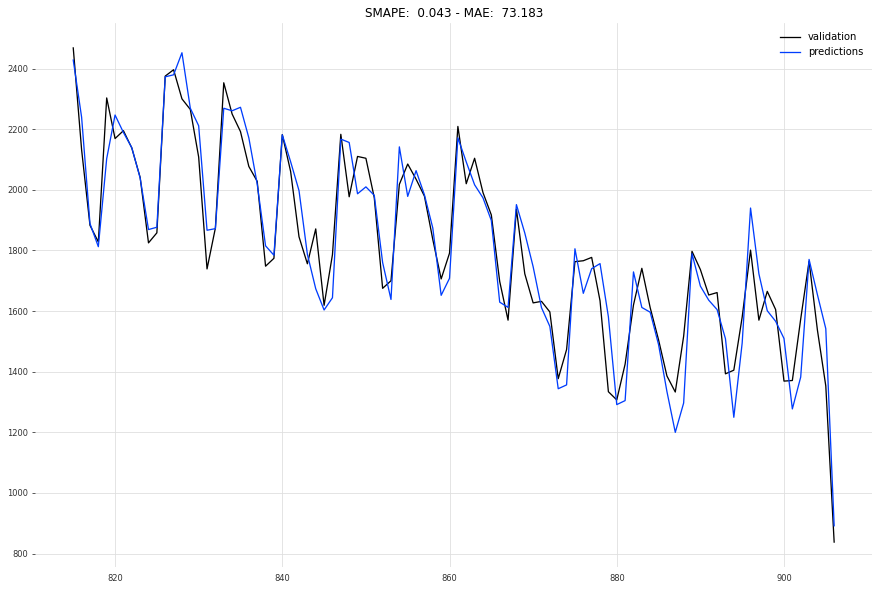

(LinearRegression(), {'MAE': 73.18266577530359, 'SMAPE': 0.0431608548624563})

In [155]:
get_score(df, plot=1)

In [156]:
df.to_csv("datasets/featured.csv", index=False)